In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm.auto import tqdm
# plt.rcParams['figure.figsize'] = (16, 9)

from termcolor import colored

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score

import torch

/home/yan/ml_projects/face_net/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from model import CustomLogReg, fit_predict, p_errors

## lfw

In [27]:
import pickle

with open('data/lfw/embs_facenet.pickle', 'rb') as f:
    data = pickle.load(f)

In [63]:
names = []
for i in range(len(data)):
    names.append(data[i][0])
names = pd.Series(names)
names.name = 'name'

embs = []
for i in range(len(data)):
    embs.append(data[i][1])
embs = pd.DataFrame(torch.cat(embs, dim=0).float().numpy())
embs.columns = [f'emb_{i}' for i in range(embs.shape[1])]

keys = []
for i in range(len(data)):
    keys.append(data[i][2].unsqueeze(1))
keys = pd.DataFrame(torch.cat(keys, dim=1).T.numpy())
keys.columns = [f'key_{i}' for i in range(keys.shape[1])]

In [64]:
df = pd.concat([names, embs, keys], axis=1)

filtered_names = pd.DataFrame(names.value_counts()[names.value_counts() >= 40].index, columns=['name'])
filtered_names['filter'] = True
names_df = pd.merge(names, filtered_names, how='left', on='name').fillna(False)

df_test = df[~names_df['filter']].copy()

df = df[names_df['filter']].copy()

/tmp/ipykernel_49985/4186764023.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  names_df = pd.merge(names, filtered_names, how='left', on='name').fillna(False)


In [65]:
class CustomLogReg:
    def __init__(self, lambda_l2:float, threshold=0.5, abs_logit=10) -> None:
        self.lambda_l2 = lambda_l2

        self.act = lambda x: 1 / (1 + np.exp(-x))

        self.threshold = threshold

    def fit(self, X:np.array, Y:np.array) -> None:
        Y_logit = Y.copy()
        Y_logit[Y == 0] = -10
        Y_logit[Y == 1] = 10
        
        X_b = np.concatenate([X.copy(), np.ones((X.shape[0], 1))], axis=1)
        self.W = np.linalg.inv(X_b.T @ X_b + self.lambda_l2 * np.identity(X_b.shape[1])) @ X_b.T @ Y_logit

    def predict_proba(self, X:np.array) -> np.array:
        
        X_b = np.concatenate([X.copy(), np.ones((X.shape[0], 1))], axis=1)
        
        return self.act(X_b @ self.W)

    def predict(self, X:np.array) -> np.array:

        return (self.predict_proba(X) > self.threshold).astype(float)

In [71]:
features = [item for item in df.columns if 'emb' in item]
keys = [item for item in df.columns if 'key' in item]
X_train, X_valid, Y_train, Y_valid = train_test_split(df, df[keys], test_size=0.2, random_state=0)

X_test, Y_test = df_test[features].copy(), df_test[keys].copy()

Y_train.reset_index(inplace=True, drop=True)
Y_valid.reset_index(inplace=True, drop=True)
Y_test.reset_index(inplace=True, drop=True)

In [72]:
log_reg = CustomLogReg(lambda_l2=1e-8, threshold=0.5)
log_reg.fit(X_train[features], Y_train)

Y_pred_train = log_reg.predict(X_train[features])
Y_pred = log_reg.predict(X_valid[features])
Y_pred_test = log_reg.predict(X_test[features])

counts_true_train = (Y_pred_train == Y_train).sum(axis=1)
counts_true = (Y_pred == Y_valid).sum(axis=1)
counts_true_test = (Y_pred_test == Y_test).sum(axis=1)

In [73]:
train_acc = []
valid_acc = []
test_acc = []

for i in range(Y_train.shape[1]):
    train_acc.append(accuracy_score(Y_pred_train.iloc[:, i], Y_train.iloc[:, i]))
    valid_acc.append(accuracy_score(Y_pred.iloc[:, i], Y_valid.iloc[:, i]))
    test_acc.append(accuracy_score(Y_pred_test.iloc[:, i], Y_test.iloc[:, i]))

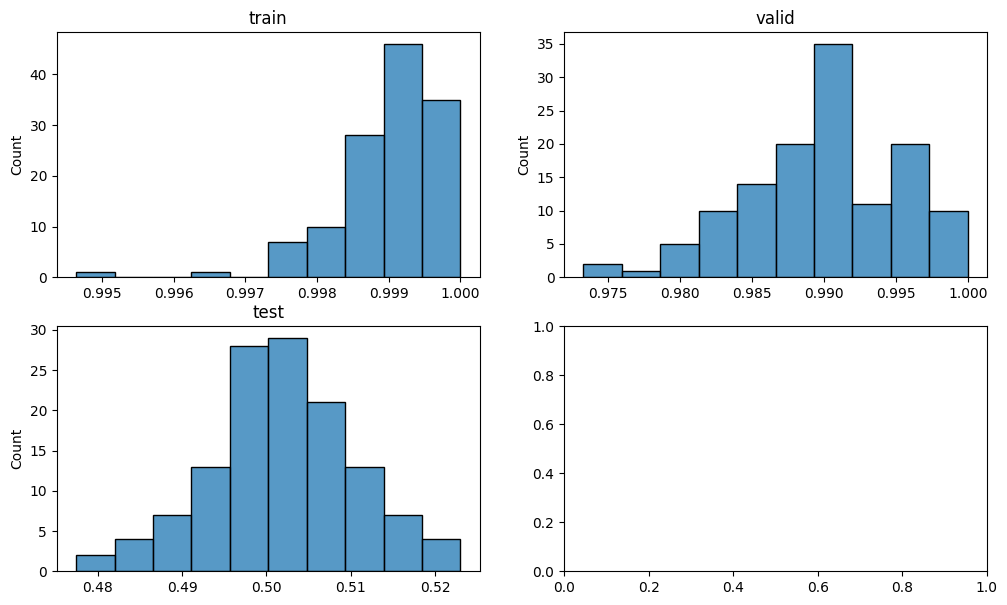

In [77]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 7))
sns.histplot(train_acc, bins=10, ax=ax1)
sns.histplot(valid_acc, bins=10, ax=ax2)
sns.histplot(test_acc, bins=10, ax=ax3)
ax1.set_title('train')
ax2.set_title('valid')
ax3.set_title('test')
plt.show()

## casia-webface

In [3]:
df = pd.read_parquet('data/casia_webface/data.parquet')

df_pure = pd.read_parquet('data/casia_webface/data_pure.parquet')

df = df[~df['name'].isin(df_pure['name'].map(lambda x: x[:6]).unique())].copy()

df = pd.concat([df, df_pure], axis=0)

test_names = pd.DataFrame({'name': df['name'].unique()[:355], 'test': True})

df = pd.merge(test_names, df, on='name', how='right').fillna(False)

df_test = df[df['test']].copy()

df = df[~df['test']].copy()

/tmp/ipykernel_2954/2663356239.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.merge(test_names, df, on='name', how='right').fillna(False)


In [4]:
df

,name,test,file,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,key_246,key_247,key_248,key_249,key_250,key_251,key_252,key_253,key_254,key_255
31281,000117,False,00015998.jpg,0.020650,0.032881,0.101294,0.070423,-0.035521,0.040918,-0.064690,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
31282,000117,False,00015995.jpg,0.043197,-0.050668,-0.028411,-0.057895,0.009248,-0.015076,-0.023021,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
31283,000117,False,00015994.jpg,-0.068613,0.010025,0.111261,0.040657,0.003200,0.000900,-0.052103,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
31284,000117,False,00016002.jpg,-0.003811,-0.024933,0.059369,0.078495,-0.008185,-0.030185,-0.085290,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
31285,000117,False,00015982.jpg,-0.035799,0.024403,0.100632,0.028177,-0.038959,0.078797,-0.025646,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35123,000029_done,False,00005081.jpg,0.063744,-0.008608,-0.003158,0.031841,-0.020845,0.002750,0.022690,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
35124,000029_done,False,00005047.jpg,0.055935,-0.055470,0.032973,0.019501,0.040554,0.005277,0.021717,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
35125,000029_done,False,00005093.jpg,0.042853,-0.059846,-0.011546,0.016203,-0.041542,-0.050793,0.026943,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
35126,000029_done,False,00005073.jpg,0.043502,-0.039084,0.006514,0.038279,0.015980,-0.032117,0.003100,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0


In [5]:
features = [item for item in df.columns if 'emb' in item]
keys = [item for item in df.columns if 'key' in item]
X_train, X_valid, Y_train, Y_valid = train_test_split(df, df[keys], test_size=0.3, random_state=0)
Y_train, Y_valid = Y_train.to_numpy(), Y_valid.to_numpy()

X_test, Y_test = df_test, df_test[keys].to_numpy().copy()

In [6]:
Y_pred_train, Y_pred_valid, Y_pred_test = fit_predict(
    X_train[features], Y_train,
    X_valid[features],
    X_test[features],
    lambda_l2=1e-8
    )

In [9]:
names = X_train['name'].unique()

i_err = {}
ii_err = {}
for name in names:
    secret_key = X_train.loc[X_train['name'] == name, keys].iloc[0:1].to_numpy()
    err_tuple = p_errors(Y_valid, Y_pred_valid, X_valid, name, secret_key, p_threshold=0.5, part_right_threshold=0.85)

    i_err[name] = err_tuple[0] * 100
    ii_err[name] = err_tuple[1] * 100

In [10]:
i_err

{'000518': 1.0554089709762533,
 '000016_done': 0.6145741878841089,
 '001080': 0.35398230088495575,
 '003046': 0.2640845070422535,
 '003231': 0.2654867256637168,
 '004269': 1.0572687224669604,
 '000029_done': 0.5272407732864675,
 '006573': 0.2643171806167401,
 '008087': 0.4420866489832007,
 '007216': 1.0600706713780919,
 '006732': 0.43975373790677225,
 '006873': 1.157613535173642,
 '001873': 0.617828773168579,
 '009771': 0.35211267605633806,
 '007610': 0.6161971830985915,
 '006674': 0.7978723404255319,
 '001292': 0.1773049645390071,
 '001499': 0.5263157894736842,
 '000010_done': 0.2652519893899204,
 '007317': 0.5286343612334802,
 '005882': 0.1773049645390071,
 '002455': 0.2664298401420959,
 '002787': 0.26690391459074736,
 '000117': 0.7957559681697612,
 '006094': 0.4424778761061947,
 '000125': 1.1393514460999123,
 '004700': 0.9623797025371827,
 '006458': 0.9708737864077669,
 '002010': 0.4393673110720563,
 '009064': 0.7036059806508356,
 '004949': 0.5300353356890459,
 '001863': 0.795755968

In [22]:
sum(ii_err.values())

0.0

In [25]:
sum(i_err.values()) / len(i_err)

0.005757575757575757

<Axes: ylabel='Count'>

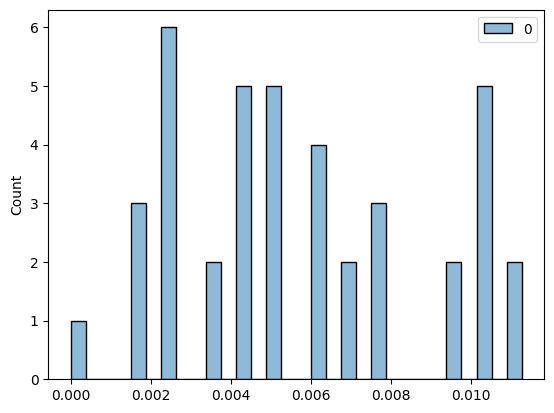

In [28]:
sns.histplot(i_err.values(), bins=30)

In [31]:
min(i_err.values())

0.0

In [32]:
log_reg = CustomLogReg(lambda_l2=1e-8)
log_reg.fit(X_train[features], Y_train)

In [33]:
names = X_train['name'].unique()

i_err = {}
ii_err = {}
for name in names:
    secret_key = X_train.loc[X_train['name'] == name, keys].iloc[0:1].to_numpy()
    err_tuple = p_errors(Y_test, Y_pred_test, X_test, name, secret_key, p_threshold=0.5, part_right_threshold=1)

    i_err[name] = err_tuple[0]
    ii_err[name] = err_tuple[1]

In [34]:
ii_err

{'000518': 0.0,
 '000016_done': 0.0,
 '001080': 0.0,
 '003046': 0.0,
 '003231': 0.0,
 '004269': 0.0,
 '000029_done': 0.0,
 '006573': 0.0,
 '008087': 0.0,
 '007216': 0.0,
 '006732': 0.0,
 '006873': 0.0,
 '001873': 0.0,
 '009771': 0.0,
 '007610': 0.0,
 '006674': 0.0,
 '001292': 0.0,
 '001499': 0.0,
 '000010_done': 0.0,
 '007317': 0.0,
 '005882': 0.0,
 '002455': 0.0,
 '002787': 0.0,
 '000117': 0.0,
 '006094': 0.0,
 '000125': 0.0,
 '004700': 0.0,
 '006458': 0.0,
 '002010': 0.0,
 '009064': 0.0,
 '004949': 0.0,
 '001863': 0.0,
 '003693': 0.0,
 '008781': 0.0,
 '003572': 0.0,
 '002194': 0.0,
 '002499': 0.0,
 '008388': 0.0,
 '000581': 0.0,
 '005993': 0.0}

In [35]:
name = '007317'
secret_key = X_train.loc[X_train['name'] == name, keys].iloc[0:1].to_numpy()
Y_auth_test = log_reg.auth(X_test[features], secret_key, p_threshold=0.5, part_right_threshold=1)

FP = Y_auth_test.astype(bool) & (X_test['name'] != name).to_numpy()
FP.sum() / Y_test.shape[0]

0.0

In [36]:
X_test[FP]

,name,test,file,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,key_246,key_247,key_248,key_249,key_250,key_251,key_252,key_253,key_254,key_255


In [28]:
i_err_grid, ii_err_grid = [], []

arange = np.round(np.arange(0, 1.05, 0.05), 4)
for i in tqdm(arange):
    for j in arange:
        
        errors_tupple = p_errors(Y_valid, Y_pred_valid, X_valid, person_id, secret_key, p_threshold=i, part_right_threshold=j)
        
        i_err_grid.append(errors_tupple[0])
        ii_err_grid.append(errors_tupple[1])

i_err_grid = pd.DataFrame(np.array(i_err_grid).reshape(arange.shape[0], arange.shape[0]), columns=arange, index=arange)
ii_err_grid = pd.DataFrame(np.array(ii_err_grid).reshape(arange.shape[0], arange.shape[0]), columns=arange, index=arange)

100%|██████████| 21/21 [00:00<00:00, 30.45it/s]


NameError: name 'i_err_grid' is not defined

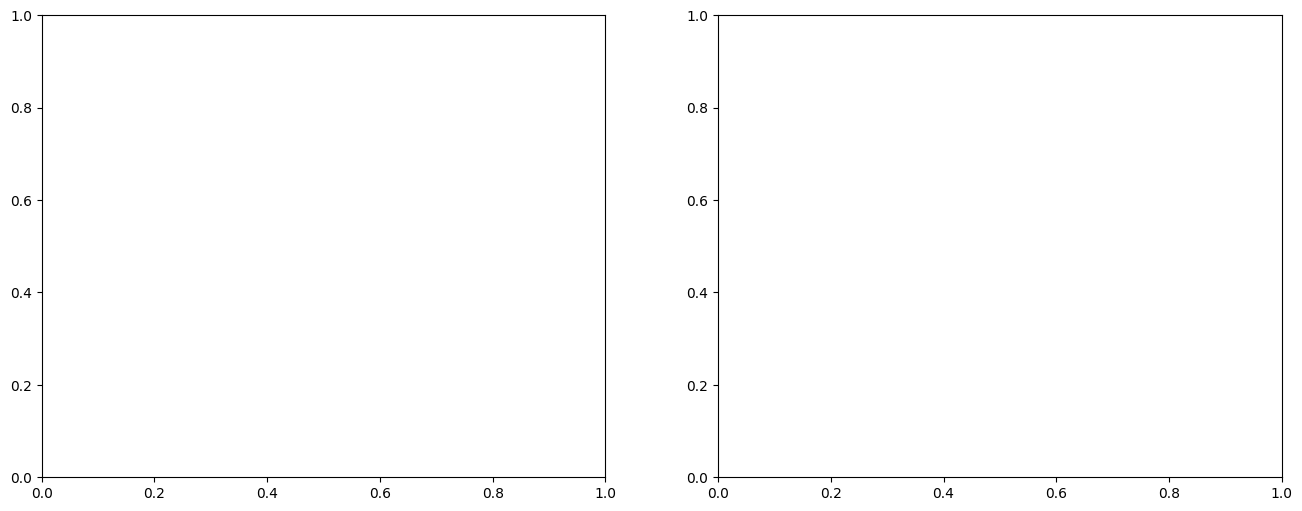

In [37]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(i_err_grid, ax=ax1, linewidths=0.1)
sns.heatmap(ii_err_grid, ax=ax2, linewidths=0.1)
ax1.set_title('I_err')
ax2.set_title('II_err')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.show()

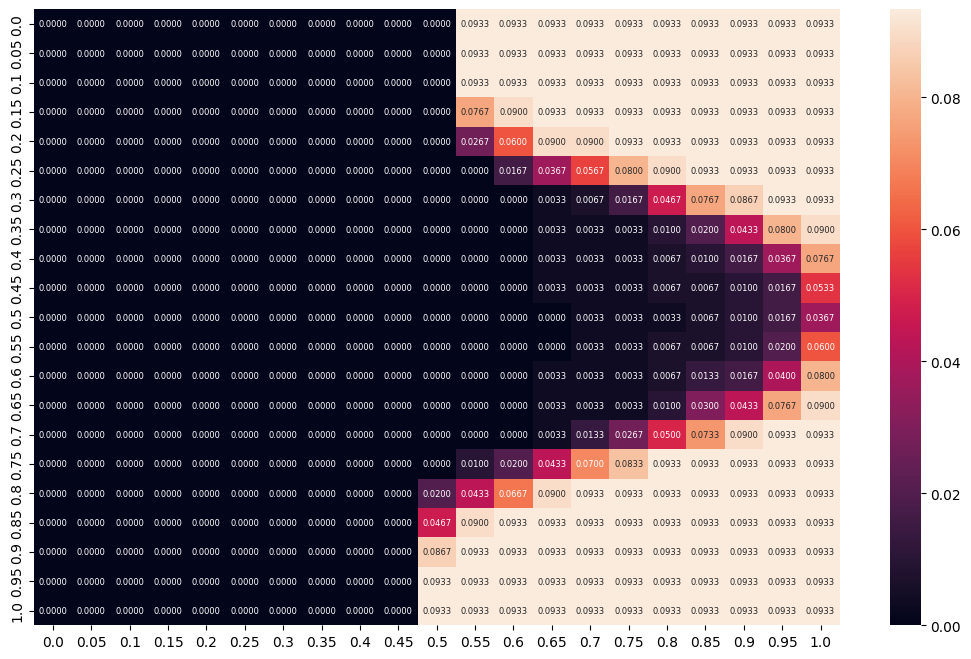

In [ ]:
plt.figure(figsize=(13, 8))
sns.heatmap(all_metrics['p_i_err'], annot=True, fmt='.4f', annot_kws={"size":6});

In [ ]:
all_metrics = {key: pd.DataFrame() for key in  ['p_i_err', 'p_ii_err', 'fpr', 'tpr', 'precision', 'recall']}

for i in tqdm(np.arange(0, 1.05, 0.05)):

    for j in np.arange(0, 1.05, 0.05):
        
        metrics = confusion_matrix(Y_test, Y_pred_test, X_test, '001292', p_threshold=i, part_right_threshold=j)

        for key in all_metrics.keys():
            all_metrics[key].loc[round(i, 4), round(j, 4)] = metrics[key]

100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


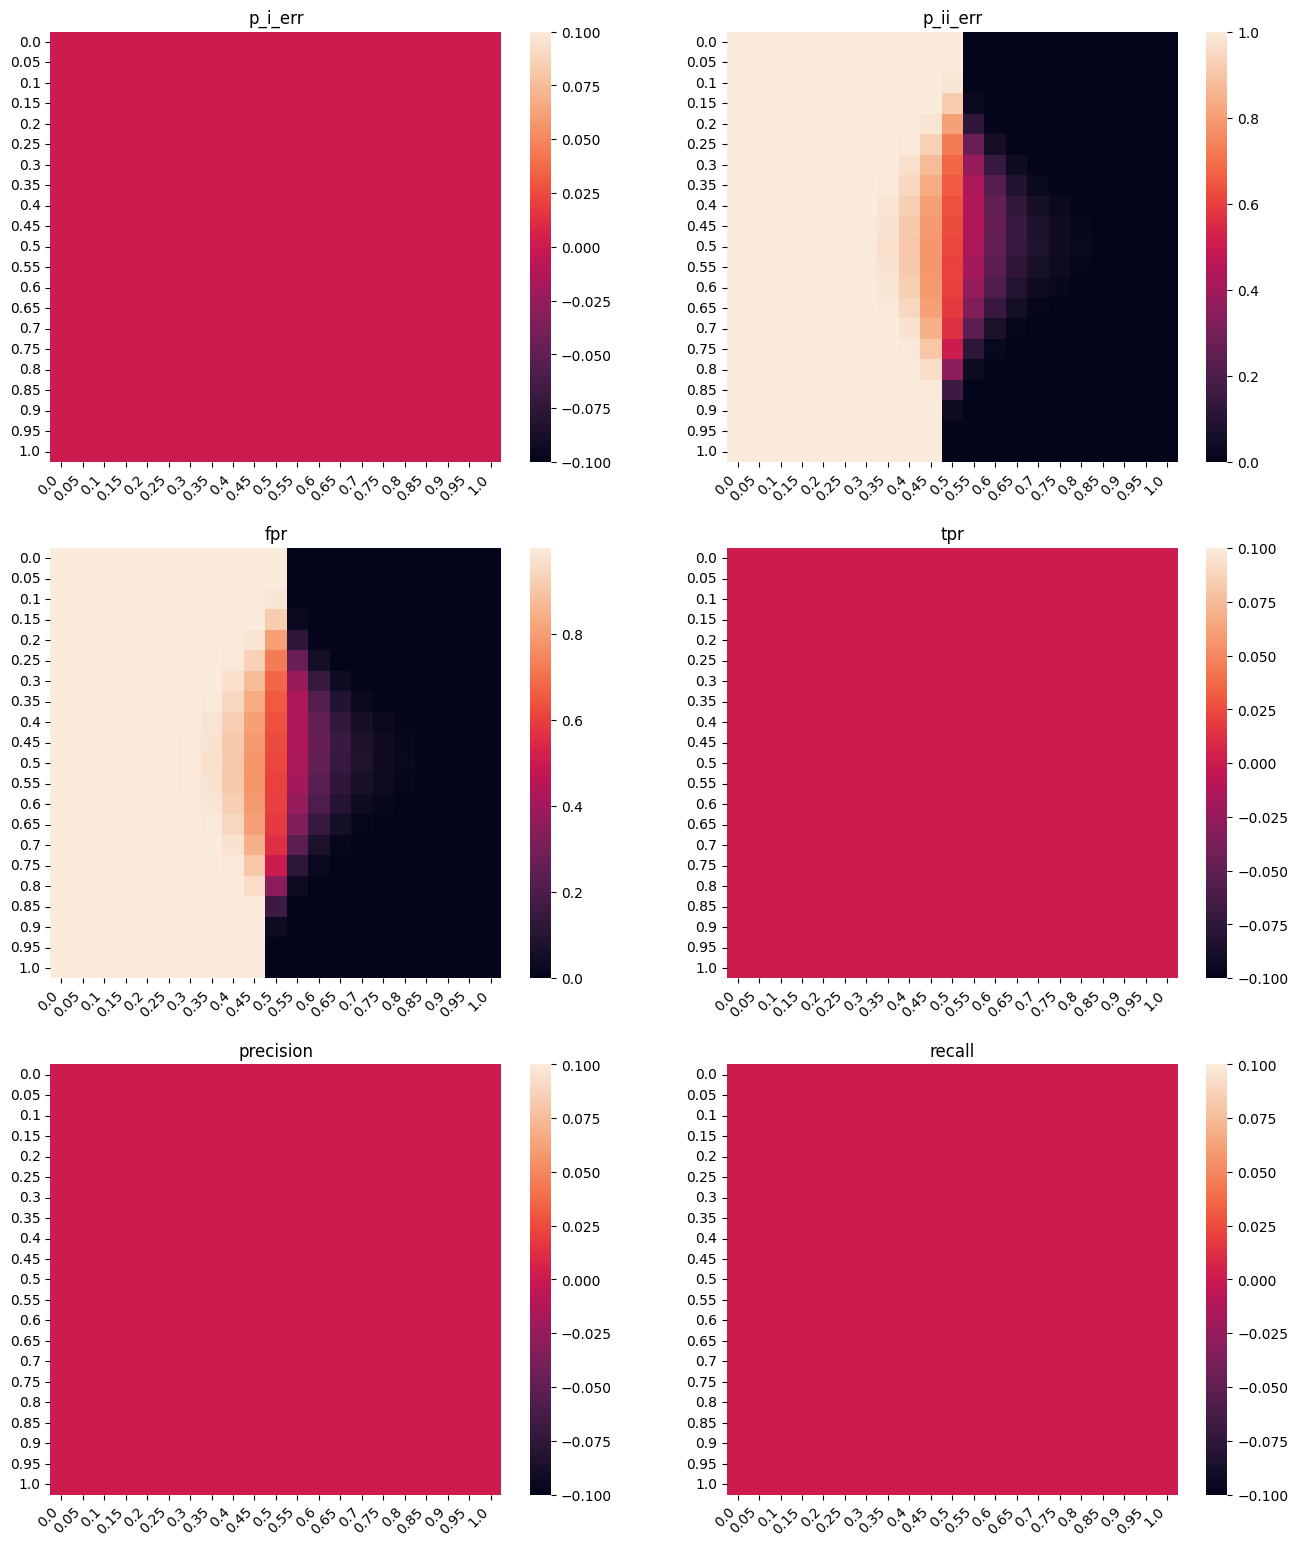

In [ ]:
_, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 19))
axes = (ax1, ax2, ax3, ax4, ax5, ax6)

for i in range(len(all_metrics)):

    key = list(all_metrics.keys())[i]

    sns.heatmap(all_metrics[key], ax=axes[i])
    axes[i].set_title(key)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.show()

count    31281.000000
mean         0.523209
std          0.148045
min          0.064357
25%          0.418367
50%          0.526637
75%          0.632351
max          0.919231
dtype: float64

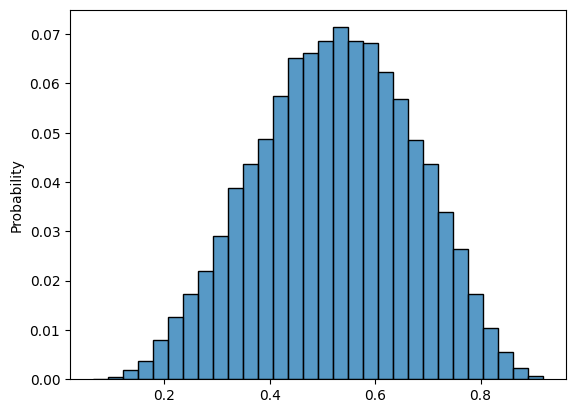

In [42]:
i = 7
sns.histplot(Y_pred_test[:, i], bins=30, stat='probability')
pd.Series(Y_pred_test[:, i]).describe()

In [45]:
i = 4
Y_pred_test[:, i].mean()

0.5817746383287773

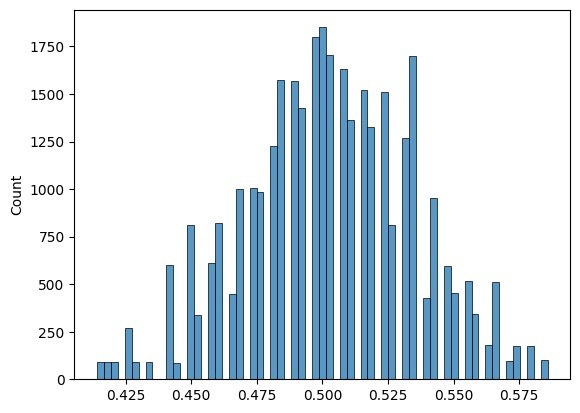

In [26]:
right_key = np.array(df.loc[df['name'] != '001292', keys].iloc[0:1])
right_key = np.concatenate([right_key] * X_test.shape[0], axis=0)
counts_match = (right_key == Y_test).sum(axis=1) / right_key.shape[1]

sns.histplot(counts_match);

## casia-webface 2 identities

In [125]:
df = pd.read_parquet('data/casia_webface/data.parquet')

df_pure = pd.read_parquet('data/casia_webface/data_pure.parquet')

df = df[~df['name'].isin(df_pure['name'].map(lambda x: x[:6]).unique())].copy()

df = pd.concat([df, df_pure], axis=0)

test_names = pd.DataFrame({'name': df['name'].unique()[:-40], 'test': True})

df = pd.merge(test_names, df, on='name', how='right').fillna(False)

df_test = df[df['test']].copy()

df = df[~df['test']].copy()

/tmp/ipykernel_587/1188477053.py:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = pd.merge(test_names, df, on='name', how='right').fillna(False)


In [126]:
df.groupby('name', as_index=False).agg({'file': 'count'})

,name,file
0,000010_done,71
1,000016_done,63
2,000029_done,47
3,000117,97
4,000125,99
5,000518,98
6,000581,100
7,001080,98
8,001292,100
9,001499,99


In [127]:
for name in df['name'].unique():
    df.loc[df['name'] == name, 'row_number'] = np.arange((df['name'] == name).sum())

In [128]:
df = df[df['row_number'] < 30]

In [130]:
features = [item for item in df.columns if 'emb' in item]
keys = [item for item in df.columns if 'key' in item]
X_train, X_valid, Y_train, Y_valid = train_test_split(df, df[keys], test_size=0.3, random_state=0)
Y_train, Y_valid = Y_train.to_numpy(), Y_valid.to_numpy()

X_test, Y_test = df_test, df_test[keys].to_numpy().copy()

In [131]:
Y_pred_train, Y_pred_valid, Y_pred_test = fit_predict(
    X_train[features], Y_train,
    X_valid[features],
    X_test[features],
    lambda_l2=1e-8
    )

In [132]:
names = X_train['name'].unique()

i_err = {}
ii_err = {}
for name in names:
    secret_key = X_train.loc[X_train['name'] == name, keys].iloc[0:1].to_numpy()
    err_tuple = p_errors(Y_valid, Y_pred_valid, X_valid, name, secret_key, p_threshold=0.5, part_right_threshold=1)

    i_err[name] = err_tuple[0]
    ii_err[name] = err_tuple[1]

In [133]:
ii_err

{'003046': 0.0,
 '001292': 0.0,
 '005993': 0.0,
 '004700': 0.0,
 '001499': 0.0,
 '000029_done': 0.0,
 '008388': 0.0,
 '002455': 0.0,
 '009771': 0.0,
 '004949': 0.0,
 '001863': 0.0,
 '006458': 0.0,
 '007610': 0.0,
 '008781': 0.0,
 '006094': 0.0,
 '006732': 0.0,
 '008087': 0.0,
 '007216': 0.0,
 '007317': 0.0,
 '002010': 0.0,
 '003231': 0.0,
 '002194': 0.0,
 '002499': 0.0,
 '000016_done': 0.0,
 '001080': 0.0,
 '005882': 0.0,
 '000518': 0.0,
 '000010_done': 0.0,
 '006573': 0.0,
 '004269': 0.0,
 '000125': 0.0,
 '000581': 0.0,
 '009064': 0.0,
 '002787': 0.0,
 '006873': 0.0,
 '003693': 0.0,
 '006674': 0.0,
 '001873': 0.0,
 '003572': 0.0,
 '000117': 0.0}

In [134]:
sum(ii_err.values())

0.0

In [135]:
sum(i_err.values()) / len(i_err)

0.024791666666666677

In [84]:
sum(i_err.values()) / len(i_err)

0.027797135114208282

In [69]:
log_reg = CustomLogReg(lambda_l2=1e-8)
log_reg.fit(X_train[features], Y_train)

In [99]:
names = X_train['name'].unique()

i_err = {}
ii_err = {}
for name in names:
    secret_key = X_train.loc[X_train['name'] == name, keys].iloc[0:1].to_numpy()
    err_tuple = p_errors(Y_test, Y_pred_test, X_test, name, secret_key, p_threshold=0.5, part_right_threshold=1)

    i_err[name] = err_tuple[0]
    ii_err[name] = err_tuple[1]

In [100]:
ii_err

{'000518': 0.0,
 '000016_done': 0.0,
 '001080': 0.0,
 '003046': 0.0,
 '003231': 0.0,
 '004269': 0.0,
 '000029_done': 0.0,
 '006573': 0.0,
 '008087': 0.0,
 '007216': 0.0,
 '006732': 0.0,
 '006873': 0.0,
 '001873': 0.0,
 '009771': 0.0,
 '007610': 0.0,
 '006674': 0.0,
 '001292': 0.0,
 '001499': 0.0,
 '000010_done': 0.0,
 '007317': 0.0,
 '005882': 0.0,
 '002455': 0.0,
 '002787': 0.0,
 '000117': 0.0,
 '006094': 0.0,
 '000125': 0.0,
 '004700': 0.0,
 '006458': 0.0,
 '002010': 0.0,
 '009064': 0.0,
 '004949': 0.0,
 '001863': 0.0,
 '003693': 0.0,
 '008781': 0.0,
 '003572': 0.0,
 '002194': 0.0,
 '002499': 0.0,
 '008388': 0.0,
 '000581': 0.0,
 '005993': 0.0}

In [101]:
sum(ii_err.values())

0.0

In [24]:
name = '007317'
secret_key = X_train.loc[X_train['name'] == name, keys].iloc[0:1].to_numpy()
Y_auth_test = log_reg.auth(X_test[features], secret_key, p_threshold=0.5, part_right_threshold=1)

FP = Y_auth_test.astype(bool) & (X_test['name'] != name).to_numpy()
FP.sum() / Y_test.shape[0]

3.007518796992481e-05

In [ ]:
X_test[FP]

,name,test,file,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,key_246,key_247,key_248,key_249,key_250,key_251,key_252,key_253,key_254,key_255
18836,009542,True,00459905.jpg,-0.044131,0.052945,0.047192,-0.001907,-0.038719,0.058901,-0.060222,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
i_err_grid, ii_err_grid = [], []

arange = np.round(np.arange(0, 1.05, 0.05), 4)
for i in tqdm(arange):
    for j in arange:
        
        errors_tupple = p_errors(Y_valid, Y_pred_valid, X_valid, person_id, secret_key, p_threshold=i, part_right_threshold=j)
        
        i_err_grid.append(errors_tupple[0])
        ii_err_grid.append(errors_tupple[1])

i_err_grid = pd.DataFrame(np.array(i_err_grid).reshape(arange.shape[0], arange.shape[0]), columns=arange, index=arange)
ii_err_grid = pd.DataFrame(np.array(ii_err_grid).reshape(arange.shape[0], arange.shape[0]), columns=arange, index=arange)

100%|██████████| 21/21 [00:00<00:00, 30.45it/s]


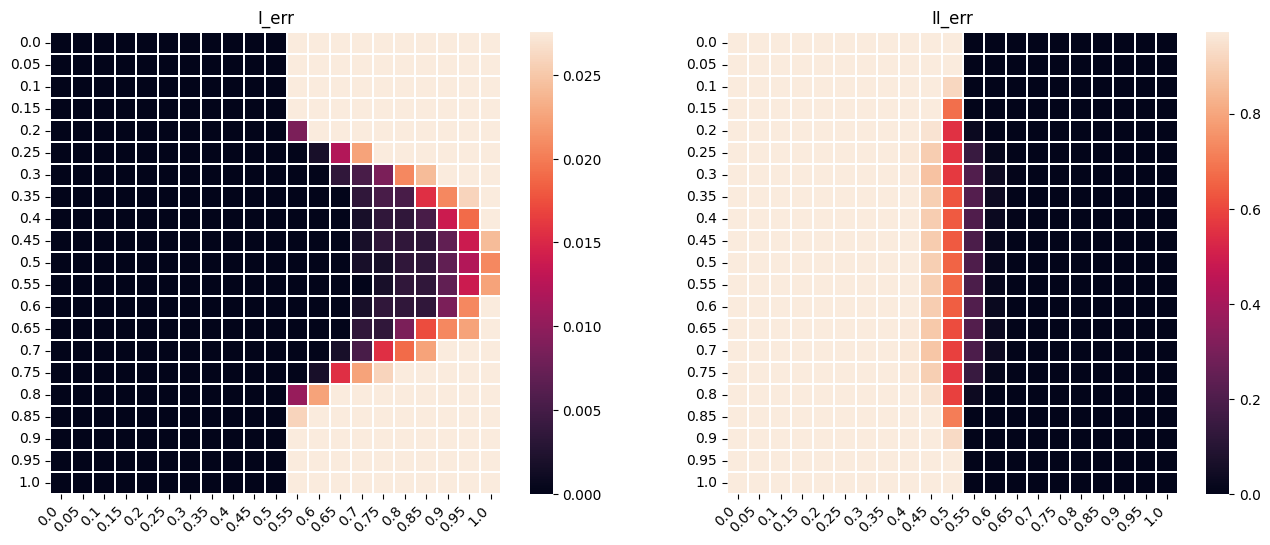

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(i_err_grid, ax=ax1, linewidths=0.1)
sns.heatmap(ii_err_grid, ax=ax2, linewidths=0.1)
ax1.set_title('I_err')
ax2.set_title('II_err')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

plt.show()

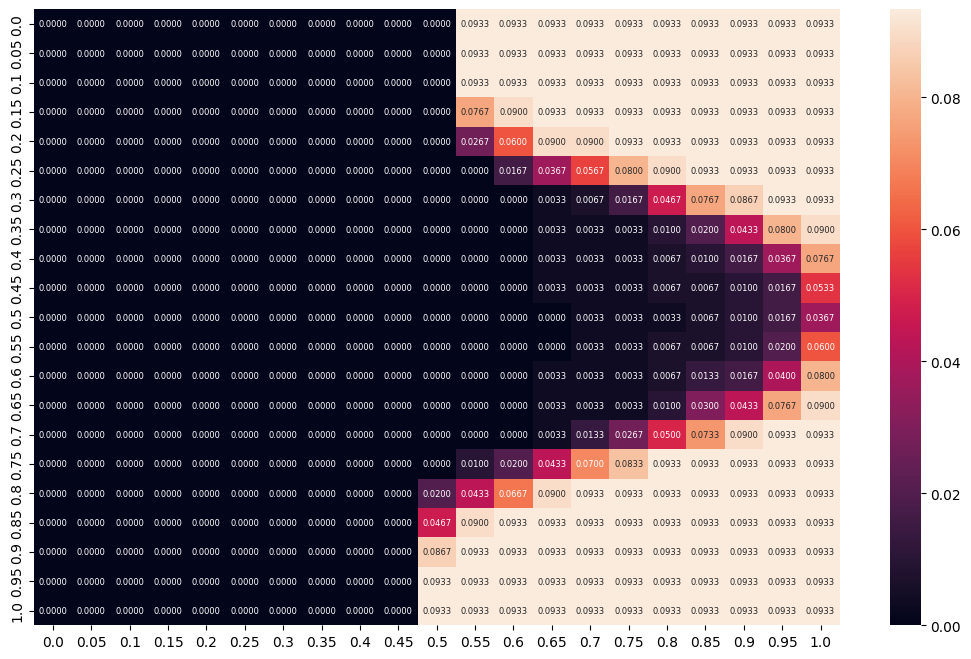

In [ ]:
plt.figure(figsize=(13, 8))
sns.heatmap(all_metrics['p_i_err'], annot=True, fmt='.4f', annot_kws={"size":6});

In [ ]:
all_metrics = {key: pd.DataFrame() for key in  ['p_i_err', 'p_ii_err', 'fpr', 'tpr', 'precision', 'recall']}

for i in tqdm(np.arange(0, 1.05, 0.05)):

    for j in np.arange(0, 1.05, 0.05):
        
        metrics = confusion_matrix(Y_test, Y_pred_test, X_test, '001292', p_threshold=i, part_right_threshold=j)

        for key in all_metrics.keys():
            all_metrics[key].loc[round(i, 4), round(j, 4)] = metrics[key]

100%|██████████| 21/21 [00:34<00:00,  1.64s/it]


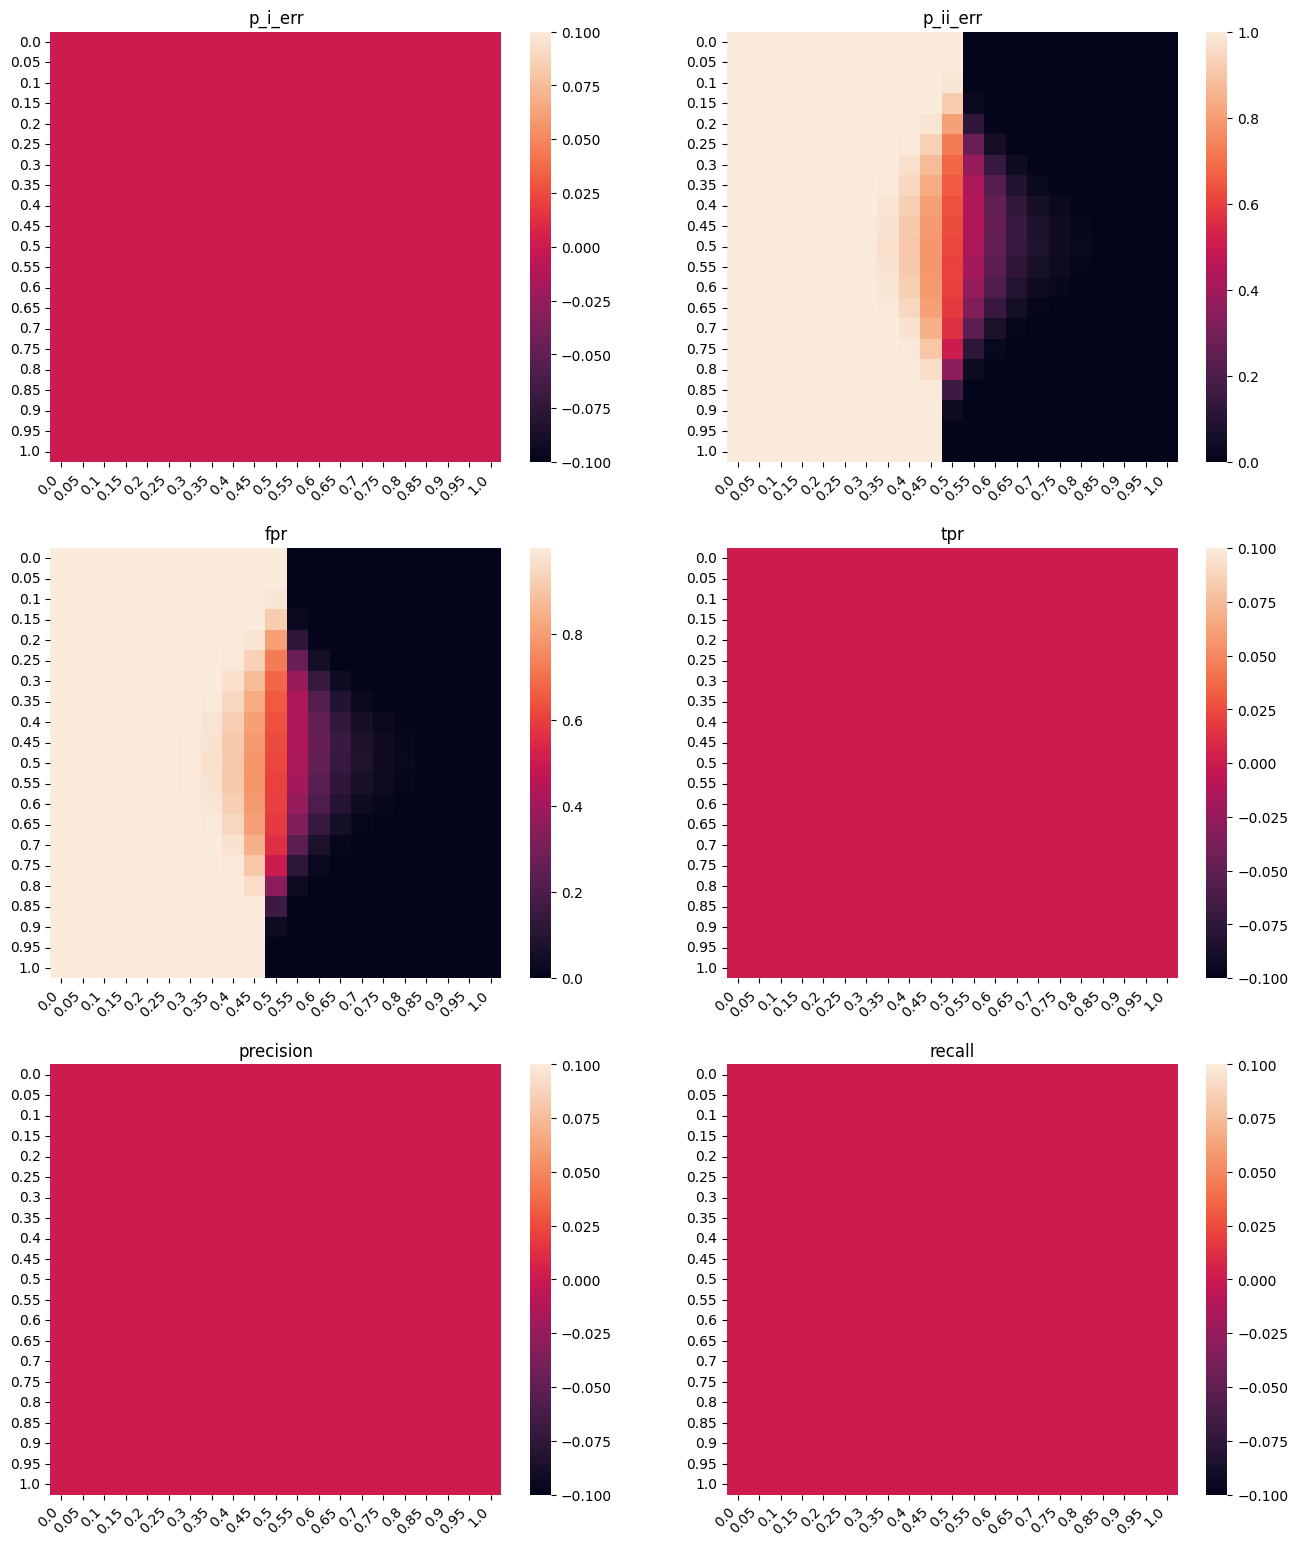

In [ ]:
_, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16, 19))
axes = (ax1, ax2, ax3, ax4, ax5, ax6)

for i in range(len(all_metrics)):

    key = list(all_metrics.keys())[i]

    sns.heatmap(all_metrics[key], ax=axes[i])
    axes[i].set_title(key)
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')

plt.show()

count    34247.000000
mean         0.582577
std          0.144463
min          0.090897
25%          0.484924
50%          0.593829
75%          0.690246
max          0.961184
dtype: float64

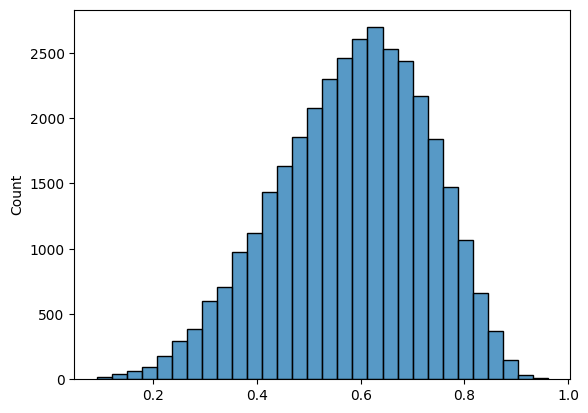

In [ ]:
i = 3
sns.histplot(Y_pred_test[:, i], bins=30)
pd.Series(Y_pred_test[:, i]).describe()

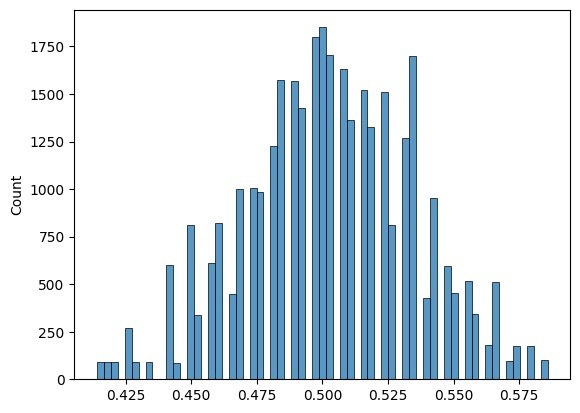

In [ ]:
right_key = np.array(df.loc[df['name'] != '001292', keys].iloc[0:1])
right_key = np.concatenate([right_key] * X_test.shape[0], axis=0)
counts_match = (right_key == Y_test).sum(axis=1) / right_key.shape[1]

sns.histplot(counts_match);